In [1]:
import pandas as pd
import cv2
import os
import seaborn as sb
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import gc

In [2]:
target_length = 50  # Duración deseada del video en fotogramas
target_size = (300, 100)  # Tamaño deseado de los fotogramas la mas grande es de 1024, 768,
output_dir = 'output_frames'  # Directorio donde se guardarán los fotogramas y las máscaras

In [3]:


def extract_frames(video_path, output_folder, frame_rate=1):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    video_capture = cv2.VideoCapture(video_path)
    count = 0
    success = True

    while success:
        success, image = video_capture.read()
        if count % frame_rate == 0 and success:
            frame_filename = os.path.join(output_folder, f"frame_{count}.jpg")
            cv2.imwrite(frame_filename, image)
        count += 1

    video_capture.release()

# Ejemplo de uso
video_path = './HMC-QU/A4C/ES00071 N_4CH_3.avi'
#video_path = './HMC-QU/A4C/ES000191 n_4CH_1.avi'
output_folder = 'output_frames_71'
extract_frames(video_path, output_folder)


In [4]:




def normalize_video_length(video_path, target_length, target_size, output_dir):
    # Crear el directorio de salida si no existe
    os.makedirs(output_dir, exist_ok=True)

    # Capturar el video
    video_capture = cv2.VideoCapture(video_path) # leer el archivo de video
    frames = []
    success, frame = video_capture.read()

    while success:
        frame = cv2.resize(frame, target_size)
        frames.append(frame)
        success, frame = video_capture.read()
    
    video_capture.release()

    # Generar máscara y hacer padding
    mask = np.ones((target_length, *target_size, 3), dtype=np.float32)
    if len(frames) < target_length:
        padding_length = target_length - len(frames)
        frames.extend([np.zeros((target_size[0], target_size[1], 3), dtype=np.float32)] * padding_length)
        mask[len(frames):] = 0  # Indicar las partes de padding en la máscara

    frames = np.array(frames[:target_length])

    # Guardar fotogramas y máscaras con nombres correspondientes
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    for i, frame in enumerate(frames):
        frame_filename = f"{video_name}_frame{i + 1}.png"
        cv2.imwrite(os.path.join(output_dir, frame_filename), frame)

    mask_filename = os.path.join(output_dir, f"{video_name}_mask.npy")
    np.save(mask_filename, mask)

    return frames, mask


# Ejemplo de uso
video_path = 'path_to_your_video.mp4'
target_length = 25  # Duración deseada del video en fotogramas
target_size = (224, 224)  # Tamaño deseado de los fotogramas la mas grande es de 1024, 768,
output_dir = 'output_frames'  # Directorio donde se guardarán los fotogramas y las máscaras

frames, mask = normalize_video_length(video_path, target_length, target_size, output_dir)

OpenCV: Couldn't read video stream from file "path_to_your_video.mp4"


In [5]:
def get_video_info(video_path):
    video_capture = cv2.VideoCapture(video_path)
    frame_count = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    video_capture.release()
    return frame_count, width, height

def analyze_videos(directory):
    video_infos = []
    for filename in os.listdir(directory):
        if filename.endswith('.mp4') or filename.endswith('.avi'):  # Ajustar según los formatos de video
            typeCam = "A4C"
            if directory == "./HMC-QU/A2C":
                typeCam = "A2C"

            
            video_path = os.path.join(directory, filename)
            frame_count, width, height = get_video_info(video_path)
            video_infos.append((filename, frame_count, width, height,typeCam, width*height, str(width)+'x'+str(height)))
    return video_infos


lsitDirectoies = ["./HMC-QU/A2C","./HMC-QU/A4C"] #arreglo de carpetas con videos de origen
# pathA2C = "./HMC-QU/A2C"
# pathA2C = "./HMC-QU/A2C"

video_infos = []
for directory in lsitDirectoies: # recorrer las dos carpetas de videos de 4 y 2 camaras 
    
    video_infos += analyze_videos(directory) # procesamos los videos para su analisis 

# Ejemplo de uso
# directory = 'path_to_your_video_directory'
# video_infos = analyze_videos(directory)

# Encontrar el video con más fotogramas y el de menor resolución
max_frames_video = max(video_infos, key=lambda x: x[1])
min_resolution_video = max(video_infos, key=lambda x: (x[2], x[3]))

print("Video con más fotogramas:", max_frames_video)
print("Video con menor resolución:", min_resolution_video)

Video con más fotogramas: ('ES00071 N_4CH_3.avi', 136, 974, 604, 'A4C', 588296, '974x604')
Video con menor resolución: ('ES00079 N_2CH_1.avi', 47, 1024, 768, 'A2C', 786432, '1024x768')


resolution
268392    222
276024     66
786432      2
480000      1
588296      1
Name: count, dtype: int64
resolutionText
636x422     222
636x434      66
1024x768      2
800x600       1
974x604       1
Name: count, dtype: int64
Número de filas: 292
  resolutionText  count  width  height
0       1024x768      2   1024     768
1        636x422    222    636     422
2        636x434     66    636     434
3        800x600      1    800     600
4        974x604      1    974     604


<Axes: xlabel='frames_bin', ylabel='count'>

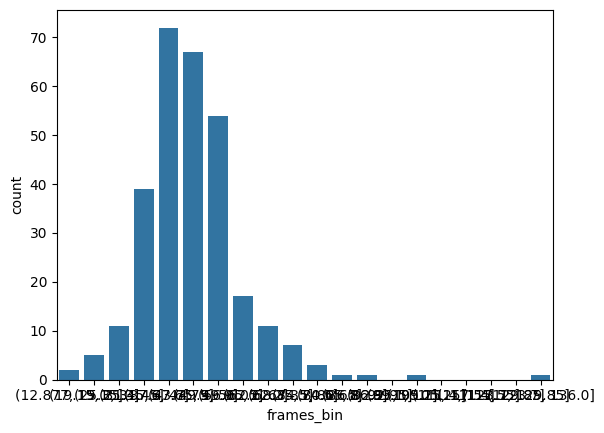

In [13]:


# print(video_infos)
# Convertir los datos en un DataFrame
df = pd.DataFrame(video_infos, columns=['fileName', 'frames', 'width', 'height','typeCam','resolution', 'resolutionText'])
df['frames_bin'] = pd.cut(df['frames'], bins=20)
print(df['resolution'].value_counts())
print(df['resolutionText'].value_counts())
# print(df['frames_bin'].value_counts())
df['frames'].min
# print(df['frames'].value_counts())
df.count()
print("Número de filas:", len(df))
# Agrupar por resolución y contar las ocurrencias
resolution_counts = df.groupby('resolutionText').size().reset_index(name='count')

# Agregar las columnas de ancho y alto
resolution_counts['width'] = resolution_counts['resolutionText'].apply(lambda x: int(x.split('x')[0]))
resolution_counts['height'] = resolution_counts['resolutionText'].apply(lambda x: int(x.split('x')[1]))

# Mostrar el resultado
print(resolution_counts)

# sb.countplot(x="resolution", data=df, hue="resolutionText")
sb.countplot(x="frames_bin", data=df)

In [14]:
df['frames'].mean()

46.41095890410959

<Axes: xlabel='resolution', ylabel='count'>

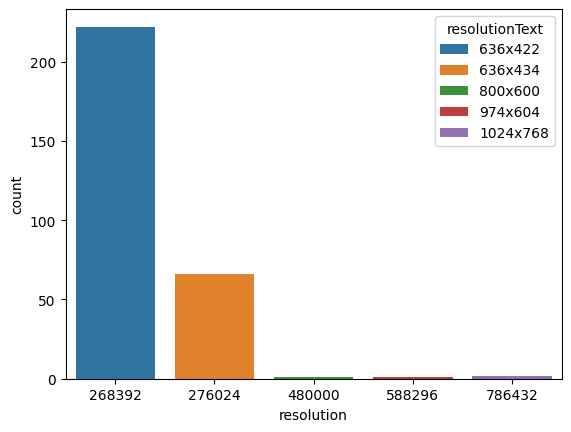

In [15]:
sb.countplot(x="resolution", data=df, hue="resolutionText")


# inicio todo


In [16]:

# Cargar el archivo CSV
df = pd.read_csv('dataSet.csv',delimiter=";")
df.info()
df = df.drop(labels="path",axis=1)
# df.drop(labels="Unnamed",axis=1)


df


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        292 non-null    object
 1   pathFolder  292 non-null    object
 2   SEG4        292 non-null    object
 3   SEG10       292 non-null    object
 4   SEG15       292 non-null    object
 5   SEG13       292 non-null    object
 6   SEG7        292 non-null    object
 7   SEG1        292 non-null    object
 8   SEG3        292 non-null    object
 9   SEG9        292 non-null    object
 10  SEG14       292 non-null    object
 11  SEG16       292 non-null    object
 12  SEG12       292 non-null    object
 13  SEG6        292 non-null    object
dtypes: object(14)
memory usage: 32.1+ KB


,pathFolder,SEG4,SEG10,SEG15,SEG13,SEG7,SEG1,SEG3,SEG9,SEG14,SEG16,SEG12,SEG6
0,./HMC-QU/A2C/ES0001_CH2_1.avi,MI,MI,MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI
1,./HMC-QU/A2C/ES000101_CH2_1.avi,non-MI,non-MI,MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI
2,./HMC-QU/A2C/ES000102_CH2_3.avi,non-MI,non-MI,MI,MI,MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI
3,./HMC-QU/A2C/ES000103_CH2_1.avi,MI,MI,MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI
4,./HMC-QU/A2C/ES000104_CH2_2.avi,non-MI,non-MI,non-MI,MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI
...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,./HMC-QU/A4C/ES00093 N_4CH_1.avi,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI
288,./HMC-QU/A4C/ES00095 N_4CH_1.avi,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI
289,./HMC-QU/A4C/ES00096 N_4CH_1.avi,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,MI,non-MI,non-MI,non-MI,non-MI
290,./HMC-QU/A4C/ES00097 N_4CH_1.avi,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI


# normalizacion de videos algoritmo

In [11]:
def normalize_video_length(video_path, target_length, target_size, output_dir):
    # Crear el directorio de salida si no existe
    os.makedirs(output_dir, exist_ok=True)

    # Capturar el video
    video_capture = cv2.VideoCapture(video_path) # leer el archivo de video
    frames = []
    success, frame = video_capture.read()

    while success:
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = np.expand_dims(frame, axis=-1)  # Agregar una dimensión para el canal
        # frames.append(frame)
        frames.append(frame)
        success, frame = video_capture.read()
    
    video_capture.release()

   # Generar máscara y hacer padding si es necesario
    countlen = len(frames)
    if countlen < target_length:
        padding_length = target_length - countlen
        padding_frames = np.zeros((padding_length, target_size[1], target_size[0], 1), dtype=np.float32)
        frames = np.concatenate((frames, padding_frames), axis=0)

        # Crear máscara con padding
        mask = np.ones((target_length, target_size[1], target_size[0], 1), dtype=np.float32)
        mask[countlen:] = 0  # Indicar las partes de padding en la máscara
    else:
        # Limitar el número de fotogramas si hay más de los necesarios
        frames = np.array(frames[:target_length])
        mask = np.ones((target_length, target_size[1], target_size[0], 1), dtype=np.float32)
        
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    for i, frame in enumerate(frames):
        frame_filename = f"{video_name}_frame{i + 1}.jpg"
        cv2.imwrite(os.path.join(output_dir, frame_filename), frame)

    mask_filename = os.path.join(output_dir, f"{video_name}_mask.npy")
    np.save(mask_filename, mask)

    return frames, mask
    # return frames






# Ejemplo de uso
# video_path = './HMC-QU/A2C/ES0001_CH2_1.avi'
# video_path = './HMC-QU/A4C/ES00092 N_4CH_1.avi'
target_length = 50 #974  # Duración deseada del video en fotogramas
target_size = (200, 70)  # Tamaño deseado de los fotogramas la mas grande es de 1024, 768,
image_folder = 'dataSetFrames'  # Directorio donde se guardarán los fotogramas y las máscaras

# Ejemplo de uso

os.makedirs(image_folder, exist_ok=True)

# limitar el scv a solo 2 registros

#df_copia = df.head(2)
# df_original = df
# df_copia = pd.concat([df.head(2), df.tail(2)])
# Seleccionar los 2 primeros registros y los 2 siguientes al índice 40
# indices_seleccionados = list(range(2)) + list(range(130, 132))  # [0, 1, 40, 41]
# indices_seleccionados = df
# df_copia = df_original.iloc[indices_seleccionados]

# df = df_copia
for video_path in df['pathFolder']:
    normalize_video_length(video_path, target_length, target_size, image_folder)

gc.collect()  # Recolector de basura
# frames, mask = normalize_video_length(video_path, target_length, target_size, image_folder)
# frames  = normalize_video_length(video_path, target_length, target_size, image_folder)

855

In [12]:
df

,pathFolder,SEG4,SEG10,SEG15,SEG13,SEG7,SEG1,SEG3,SEG9,SEG14,SEG16,SEG12,SEG6,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,./HMC-QU/A2C/ES0001_CH2_1.avi,MI,MI,MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,NaN,NaN,NaN,NaN
1,./HMC-QU/A2C/ES000101_CH2_1.avi,non-MI,non-MI,MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,NaN,NaN,NaN,NaN
2,./HMC-QU/A2C/ES000102_CH2_3.avi,non-MI,non-MI,MI,MI,MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,NaN,NaN,NaN,NaN
3,./HMC-QU/A2C/ES000103_CH2_1.avi,MI,MI,MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,NaN,NaN,NaN,NaN
4,./HMC-QU/A2C/ES000104_CH2_2.avi,non-MI,non-MI,non-MI,MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,./HMC-QU/A4C/ES00093 N_4CH_1.avi,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,NaN,NaN,NaN,NaN
288,./HMC-QU/A4C/ES00095 N_4CH_1.avi,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,NaN,NaN,NaN,NaN
289,./HMC-QU/A4C/ES00096 N_4CH_1.avi,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,MI,non-MI,non-MI,non-MI,non-MI,NaN,NaN,NaN,NaN
290,./HMC-QU/A4C/ES00097 N_4CH_1.avi,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,non-MI,NaN,NaN,NaN,NaN


# cargar archivos de video para procesarlos

In [13]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img




def load_images_and_labels(df, image_folder, target_size):
    # while True:
        # for start in range(0, len(df), batch_size):
    images = []
    masks = []
    labels = []

    # end = min(start + batch_size, len(df))
    # batch_df = df[start:end]  
    
    for index, row in df.iterrows():
        video_base_name = os.path.splitext(os.path.basename(row['pathFolder']))[0]
        
        # Cargar máscara del video
        mask_filename = os.path.join(image_folder, f"{video_base_name}_mask.npy")
        mask = np.load(mask_filename)
        

        if index == 0:
            print("Dimensiones de la máscara:", mask.shape)
            print("Tipo de datos de la máscara:", mask.dtype)

        for frame_idx in range(1, target_length+1):  # Suponiendo que normalizamos a 30 frames por video
            image_path = os.path.join(image_folder, f"{video_base_name}_frame{frame_idx}.jpg")
            image = load_img(image_path, target_size=target_size, color_mode="grayscale")
            image = img_to_array(image)
            images.append(image)

        masks.extend(mask[:, :, 0, 0])  # Añadir los valores de la máscara para cada frame

            # # Cargar máscara
            # mask_path = os.path.join(mask_folder, f"{video_base_name}_mask.npy" f"{video_base_name}_frame{frame_idx}_mask.npy")
            # mask = np.load(mask_path)
            # masks.append(mask)
        
        # Etiquetas para cada frame del video
        label = row.iloc[1:].values  # Obtener las etiquetas de los segmentos
        # print(labels)
        binary_label = [1 if segment == 'MI' else 0 for segment in label]
        labels.extend([binary_label] * target_length)  # Replicar las etiquetas para cada frame


    
    
    return np.array(images), np.array(labels), np.array(masks)

# Cargar imágenes y etiquetas
# image_folder = '/outpup_frames'
image_folder = 'dataSetFrames'  # Directorio donde se guardarán los fotogramas y las máscaras
images, labels, masks = load_images_and_labels(df, image_folder,target_size )
# batch_size = 8
# batch_gen = load_images_and_labels(df, image_folder, target_size, batch_size)

# Obtener el primer batch
# images, masks, labels = next(batch_gen)
images = images / 255.0
# Verificar las dimensiones
# print("Dimensiones de las imágenes:", images.shape)
# print("Dimensiones de las máscaras:", masks.shape)
# print("Dimensiones de las etiquetas:", labels.shape)





Dimensiones de la máscara: (50, 70, 200, 1)
Tipo de datos de la máscara: float32


In [14]:
images.shape

(14600, 200, 70, 1)

In [16]:
masks.shape

(14600, 70)

In [18]:
labels.shape

(14600, 12)

In [17]:
for row in labels:
    print(row)

[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0 0 0 0 0 0 0]
[1 1 1 0 0 0

# creacion de red neuronal


preparar datos de entrenamiento

In [37]:
images.shape
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard

In [47]:
import tensorflow as tf

modeloDenso = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape= (200, 70,1)),
    tf.keras.layers.Dense(150,activation="relu"),
    tf.keras.layers.Dense(150,activation="relu"),
    tf.keras.layers.Dense(150,activation="relu"),

    tf.keras.layers.Dense(12,activation="softmax")
])

modeloCNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation="relu", input_shape=(200,70,1)),
    
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(12, activation = "softmax")
])

modeloCNN2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3), activation="relu", input_shape=(200,70,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(250, activation="relu"),
    tf.keras.layers.Dense(12, activation = "sigmoid")
])


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
modeloDenso.compile(optimizer="adam",
                    loss="binary_crossentropy",
                    metrics=["accuracy"])



# modeloCNN2.compile(optimizer="adam",
#                     loss="binary_crossentropy",
#                     metrics=["accuracy"])

In [21]:
tensorBorardDenso = TensorBoard(log_dir='logs/denso')
modeloDenso.fit(images,one_hot_labels,batch_size=32, validation_split=0.15, epochs=100, callbacks=[tensorBorardDenso])

Epoch 1/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.1749 - loss: 0.2880 - val_accuracy: 0.0616 - val_loss: 0.4034
Epoch 2/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2061 - loss: 0.0740 - val_accuracy: 0.0813 - val_loss: 0.5320
Epoch 3/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1932 - loss: 0.0630 - val_accuracy: 0.0868 - val_loss: 0.6287
Epoch 4/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.2185 - loss: 0.0542 - val_accuracy: 0.0991 - val_loss: 0.6851
Epoch 5/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2075 - loss: 0.0563 - val_accuracy: 0.0918 - val_loss: 0.7017
Epoch 6/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.2168 - loss: 0.0671 - val_accuracy: 0.0671 - val_loss: 0.6732
Epoch 7/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1954 - loss: 0.0574 - val_accuracy: 0.0447 - val_loss: 0.7593
Epoch 8/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1911 - loss: 0.0568 - val_acc

In [46]:

modeloCNN.compile(optimizer="adam",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

tensorBorardCNN = TensorBoard(log_dir='logs/CNN')
modeloCNN.fit(images,labels,batch_size=32, validation_split=0.15, epochs=100, callbacks=[tensorBorardCNN])

Epoch 1/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 53s 136ms/step - accuracy: 0.1033 - loss: 7178854.0000 - val_accuracy: 0.0000e+00 - val_loss: 76683456.0000
Epoch 2/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 54s 139ms/step - accuracy: 0.0871 - loss: 992728832.0000 - val_accuracy: 0.0228 - val_loss: 2799923968.0000
Epoch 3/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 53s 136ms/step - accuracy: 0.0841 - loss: 10650213376.0000 - val_accuracy: 0.6516 - val_loss: 17234984960.0000
Epoch 4/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 53s 136ms/step - accuracy: 0.0876 - loss: 38739685376.0000 - val_accuracy: 0.0685 - val_loss: 22216824832.0000
Epoch 5/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 54s 140ms/step - accuracy: 0.0784 - loss: 101338046464.0000 - val_accuracy: 0.0913 - val_loss: 47689068544.0000
Epoch 6/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 53s 136ms/step - accuracy: 0.0743 - loss: 190088118272.0000 - val_accuracy: 0.0685 - val_loss: 101429354496.0000
Epoch 7/100
388/388 ━━━━━━━━━━━━━━━━━━━━ 52s 134ms/step - accuracy: 0.0866 - loss: 33066795